# HSE Salary Prediction

### Reduce Cost of Job Offer Rejections by HSE Candidates

__author__ = "Daniel Hershberger"
__copyright__ = "Copyright 2019, Pentafusion"
__email__ = "dh@pentafusion.com"

## Table of Contents

### The Problem
- [The Cost of Job Offer Rejections by HSE Candidates](#defineproblem)
- [Salary Prediction Model Objectives](#defineobjective)

### Helper Library
- [Import Packages](#importpackages)
- [Data Methods](#datamethods)
- [Feature Generation Methods](#featuregenerationmethods)
- [Model Container Methods](#modelcontainermethods)

### Data Discovery
- [Insights via Exploratory Data Analysis](#insightsfromexploratorydataanalysis)
- [Possible Solutions](#possiblesolutions)

### Model Development
- [Define Model Parameters](#definemodelparameters)
- [Create a Data Object](#createadataobject)
- [Feature Engineering](#featureengineering)
- [Create Model Container - Add Baseline and Ensemble Models](#createmodelcontainer)
- [Cross Validate Model - Select, Fit and Score Test Data with Best Model](#crossvalidatemodel)
- [Summarize Results](#summarizeresults)

### Model Deployment
- [Measure Efficacy](#measureefficacy)

### Conclusion
- [What to Optimize](#whattooptimize)
- [Retention Plan](#retentionplan)
- [Final Thoughts](#finalthoughts)


### The Problem:
<a id='defineproblem'></a>
#### The cost of HSE job offer rejections

One of the most neglected costs in Human Resources is the **10% of job offers rejected by High Salary Expectation ("HSE") candidates.** 

While a few job sites have taken a shot at salary prediction, most fail to recognize better salary estimates can reduce the cost of high salary expection ("HSE") job offer rejections for employers.  The hiring process holds complexity and subtle nuances which is an opportunity for continuous data science innovation.  There will always be some irreducible error with human behavior, but in the same way Zillow revolutionized a baseline range for home values, the goal of this work is to predict a baseline salary range for public job postings. 

This salary prediction model aims to mitigate the waste of employers interviewing candidates who expect higher salaries than offered by the position.  According to Glassdoor, the average U.S. company spends about **4,000 USD to hire a new employee**, and takes on average **42 days to fill an open position**.  

Today, most applicant screening softwares efficiently filter out applicants who do not qualify for positions, but most algorithms fall short of filtering out applicants who expect higher salaries.  According to Jobvite 2017 Recruiting Funnel Benchmark Report, **17% of candidates will reject a job offer**, up 6% since 2015.  According to the 2017 Recruiter Sentiment Study by the MRI Network, **57% of candidates reject job offers due to compensation**.  

Publicly displaying salary predictions should act as a filter that discourages HSE candidates from entering into a company's hiring pipeline.  An accurate salary prediction is good for both job seekers and companies because it mitigates the chances of everything falling apart at the last minute due to misaligned salary expectations.  

Note, the recruitment process of high-level employees can cost multiples of the average...

**Cost of HSE Candidates include:** 
- Cost of advertising the job posting (paid clicks from applicants expecting a higher salary)
- Cost of time spent reviewing applications and interviewing "higher salary expectation" candidates.
- Lost productivity (job seekers/employers time wasted if salary expectations don't match)

**Cost of HSE Candidates** = (Advertising + Application Review + Interviews + Lost Productivity) x (# Job Offers x HSE Rejection Rate)

**Cost per HSE Candidate** = 600 + 600 + 2,000 + 800 = 4,000 USD

**# of HSE Candidates per 1k Job Offers** = 1,000 x (0.17 * 0.57) = 97 HSE Candidates

**Cost of HSE Candidates per 1k Job Offers** = 4,000 x 97 = 388,000 USD

### Salary Prediction Model Objectives:
#### Reduce the cost of HSE candidate job offer rejections

- To understand which job posting features contribute most to salary.

- To tune a machine learning model that predicts the salary range of public job postings within 15%.

- To implement a salary estimate that discourages HSE candidates from sending applications to lower salary positions.

# Helper Library:

<a id='importpackages'></a>
### Import Packages

In [4]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

<a id='datamethods'></a>
### Data Methods

In [5]:
class Data:
    def __init__(self, train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col):
        '''create train and test dataframe'''
        #create new copies instead of references
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.feature_cols = cat_cols + num_cols
        self.target_col = target_col
        self.id_col = id_col
        self.label_encoders = {}
        self.train_df = self._create_train_df(train_feature_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
    
    def label_encode_df(self, df, cols):
        '''creates one label encoder for each column in the data object instance'''
        for col in cols:
            if col in self.label_encoders:
                #if label encoder already exists for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
    
    def inverse_encode_df(self, df, cols):
        '''does inverse label encoding'''
        for col in cols:
            if col in self.label_encoders:
                self._inverse_label_encode(df, col)  
            else:
                raise ValueError("label_encoders must be define for each col before calling inverse_encode_df")

    def _label_encode(self, df, col, le=None):
        '''label encodes data'''
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
        
    def _inverse_label_encode(self, df, col):
        '''inverse label encodes data'''
        le = self.label_encoders[col]
        df[col] = le.inverse_transform(df[col])
 
    def _create_train_df(self, train_feature_df, train_target_df, preprocess=True, label_encode=True):
        '''loads and merges training data features and targets, preprocesses data, encodes data'''
        train_feature_df = self._load_data(train_feature_file)
        train_target_df = self._load_data(train_target_file)
        train_df = self._merge_dfs(train_feature_df, train_target_df)
        if preprocess:
            train_df = self._clean_data(train_df)
            train_df = self._shuffle_data(train_df)
        if label_encode:
            self.label_encode_df(train_df, self.cat_cols)
        return train_df
    
    def _create_test_df(self, test_file, label_encode=True):
        '''loads and label encodes test data'''
        test_df = self._load_data(test_file)
        if label_encode:
            self.label_encode_df(test_df, self.cat_cols)
        return test_df
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def _merge_dfs(self, df1, df2, key=None, left_index=False, right_index=False):
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    def _clean_data(self, df):
        '''remove rows that contain salary <= 8.5 or duplicate job IDs'''
        df = df.drop_duplicates(subset='jobId')
        df = df[df.salary>8.5]
        return df
    
    def _shuffle_data(self, df):
         return shuffle(df).reset_index()

<a id='featuregenerationmethods'></a>
### Feature Generation Methods

In [6]:
class FeatureGenerator:
    def __init__(self, data):
        '''initializes class and creates groupby object for data'''
        self.data = data
        #able to generate features for new companies, but less accurate
        #self.cat_cols = ['jobType', 'degree', 'major', 'industry']
        self.cat_cols = data.cat_cols
        self.groups = data.train_df.groupby(self.cat_cols)
        
    def add_group_stats(self):
        '''adds group statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._get_group_stats()
        group_stats_df.reset_index(inplace=True)
  
        #merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.cat_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.cat_cols, fillna=True)      
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, cat_cols=group_stats_cols)  
        
    def _get_group_stats(self):
        '''calculates group statistics'''
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df
        
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_col_lists(self, data, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        data.num_cols.extend(num_cols)
        data.cat_cols.extend(cat_cols)
        data.feature_cols.extend(num_cols + cat_cols)

<a id='modelcontainermethods'></a>
### Model Container Methods

In [18]:
class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl
        
    def add_model(self, model):
        self.models.append(model)

    def cross_validate(self, data, k=5, num_procs=1):
        '''cross validate models using given data'''
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))

        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()
        

# Data Discovery:

<a id='exploratorydataanalysisinsights'></a>
### Insights via Exploratory Data Analysis

The dataset is clean with no missing values or duplicates.  At 1 million records, the size of this dataset should be large enough to handle multiple dimensions and help prevent over-fitting the model.  Find the summarized key points from this EDA exercise below.

#### Summary Statistics (salary):
- Dataset Records:  1,000,000 
- Average:  116.1
- Standard Deviation: 38.7
- Minimum: 0.0
- Maximum:  301.0
- U Outlier:  220.5 -- 7,117 records
- L Outlier:  8.5 -- 5 records

#### Posive Relationship (feature to salary):
- jobType (object)
- degree (object)
- yearsExperience (int 64)

#### Negative Relationship (feature to salary):
- milesFromMetropolis (int 64)

#### Minor Relationship to (feature to salary):
- major (object)
- industry (object)

#### No Relationship (feature to salary):
- jobId (object)
- companyId (object)

#### Drop Features From Training Set:
- L Outlier with salary < 8.5
- jobId

<a id='possiblesolutions'></a>
### Possible Solutions

- My hypothesis is that by doing a little feature engineering with group stats fed into ensemble algorithms like Random Forest and Gradient Boosting Regressor will perform best at predicting the salaries.  This hunch is based on EDA and the high likelihood that non-linear relationships exist.
- Linear Regression and DummyRegressor(strategy = mean) models will be built for benchmarking ensemble results.

# Model Development

<a id='definemodelparameters'></a>
### Define Model Parameters

In [8]:
#move working directory to correct location
os.chdir('/Users/HershHouse11/Desktop/GIT/salarypredictionproject')

#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_feature_file = 'data/train_features_sp.csv'
train_target_file = 'data/train_salaries_sp.csv'
test_file = 'data/test_features_sp.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#turn feature engineering on/off
engineer_features = True

<a id='createadataobject'></a>
### Create a Data Object

In [9]:
data = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

<a id='featureengineering'></a>
### Feature Engineering

In [10]:
if engineer_features:
    feature_generator = FeatureGenerator(data)
    feature_generator.add_group_stats()

In [11]:
data.train_df.head()

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_max,group_min,group_std,group_median
0,31332,JOB1362684439019,61,0,2,7,0,13,84,137,124.060000,194,79,25.489021,120.0
1,205693,JOB1362684613380,62,2,4,7,0,6,28,92,111.215686,174,70,26.464553,112.0
2,760401,JOB1362685168088,60,4,2,7,2,4,48,86,104.589286,164,57,25.616597,99.0
3,160453,JOB1362684568140,27,1,2,7,2,6,52,121,142.628571,220,82,30.789689,141.5
4,159656,JOB1362684567343,19,2,1,0,5,9,31,170,146.700000,176,114,24.463351,147.5


In [12]:
data.test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,group_mean,group_max,group_min,group_std,group_median
0,JOB1362685407687,27,5,2,7,3,22,73,108.208333,173.0,61.0,26.037582,107.0
1,JOB1362685407688,5,4,4,7,0,20,47,71.482759,129.0,36.0,21.142990,67.5
2,JOB1362685407689,2,2,3,0,3,17,9,157.500000,181.0,144.0,17.291616,152.5
3,JOB1362685407690,14,5,2,7,4,14,96,122.379310,176.0,78.0,21.599080,121.0
4,JOB1362685407691,30,4,1,0,4,10,44,110.333333,155.0,83.0,24.443131,103.5


<a id='createmodelcontainer'></a>
### Create Model Container - Add Baseline and Ensemble Models

In [13]:
models = ModelContainer()

#create models -- hyperparameter tuning already done by hand for each model
models.add_model(DummyRegressor(strategy = 'mean'))
models.add_model(LinearRegression())
models.add_model(RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                                       max_features=8, verbose=verbose_lvl))
models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))

<a id='crossvalidatemodels'></a>
### Cross Validate Models - Select, Fit and Score Test Data with Best Model

In [14]:
models.cross_validate(data, k=2, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models.best_model_predict(data.test_df[data.feature_cols])

<a id='summarizeresults'></a>
### Summarize Results


Model Summaries:


 DummyRegressor(constant=None, quantile=None, strategy='mean') - MSE: 1499.0196591080476

 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) - MSE: 358.17859623439244

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=80,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False) - MSE: 313.5338191119292

 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
             

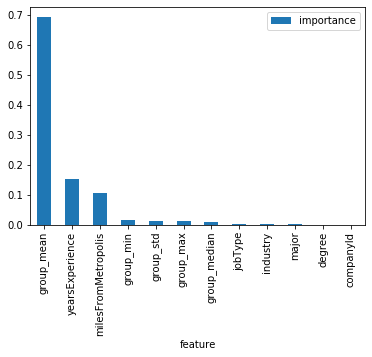

In [15]:
models.print_summary()

# Model Deployment

<a id='measureefficacy'></a>
### Measure Efficacy

We'll skip this step since we don't have the outcomes for the test data.

# Conclusion:

<a id='whattooptimize'></a>
### What to Optimize

NLP methods like TFIDF, Bag of Words or n-grams likely hold additional insights into the unstructured data of public job postings.  Beyond simple group stats, a company may want to invest more time and resources into feature engineering.    

In summary, further domain knowledge and feature engineering hold the greatest optimization potential for the HSE Salary Prediction Model.

<a id='retentionplan'></a>
### Retention Plan

Since this model is being used to systematically deter human behavior, a company should refrain from soley relying on the output of this model to completely deter HSE candidates from applying to lower salary positions. Instead, a company should hedge their likelihood of success by measuring the model's probability of deterence, and if necessary, designing a 2nd layer screening system to mitigate HSE candidates flowing deeper into the hiring pipeline. 

For an employer, this 2nd layer screening system could look like a well designed phone screening question or a survey emailed before the company invests human resources into a full fledged hiring process for any candidate.  

The hypothetical roll out for a job site like Indeed.com would be to publically display this HSE salary prediction model on every listing based on it's structured Job Posting fields.  With our dataset, we see an MSE = 313 and can expect a predicted salary +/- 17, which would be a helpful estimate for both job seekers and employers.

<a id='finalthoughts'></a>
### Final Thoughts


**Employer KPI:** Lower HSE Job Offer Rejection Rate -- Human Resources Cost Savings

**Model KPI:** Lower MSE of Salary Predction -- Increased Trust and Utility

**Jobsite KPI:** Salary Estimate UI Design -- Conversion Rate (Paid Click to Application, User Engagement/Success Rate)

With this Gradient Boosting Regressor model performing at MSE = 313, we can examine the RMSE = 17 and mean salary = 116 to approximate 95% of our predictions of salary will be within +/- 15%.

Aside from HSE candidate deterence, this type of model at scale could also help employers estimate the market value of current employees and offer salary recommendations for their open positions.   

**Solution 1:**

Display the salary estimate on public job site listings.  

This estimate will deter high salary expectation candidates from entering into the hiring process pipeline and allows ATS systems to filter out unqualified candidates who apply to high salary positions.

The salary estimate serves as a common baseline for negotiation, similar to Zillow's estimate for home values.

**Solution 2:** 

Develop a market research system using salary prediction for employers to score market value of current employees versus their actual compensation.  Employers can also receive salary recommendations for their open job postings. 

The most common objection to this type of estimation model is "Why couldn't the company just post the actual salary of the position on the job site?".  Well, the company could and probably should do that in most cases.  But, the same question could be asked of Zillow, "Why can't Zillow just ask homeowners what price they would accept for their house?". It's important to look at the benefit of market value estimates from a transparency point of view.

On a final note, this estimatation model promotes transparency and informs employees and employers of a fair salary range based on market value.